# Fitting a drift diffusion model to SET data

## TODOs & thoughs
* Load pupil data
* Integrate pupil pattern (lin, quad, lin-quad) as predictor in regression -> http://ski.clps.brown.edu/hddm_docs/tutorial_python.html#fitting-regression-models
* Better explanation of regression (just do `m = hddm.models.HDDMRegressor(data, 'v ~ BOLD')`) -> http://ski.clps.brown.edu/hddm_docs/howto.html#estimate-a-regression-model
* Include within-subjects effects using patsy package -> http://ski.clps.brown.edu/hddm_docs/tutorial_python.html#within-subject-effects

## Problems and solutions
* `ValueError: Buffer dtype mismatch, expected 'double' but got 'long'` -> rts must be coded in seconds (not miliseconds)
* `KeyError: 'rt'` -> column names must match up with example here: http://ski.clps.brown.edu/hddm_docs/tutorial_python.html
* `ZeroProbability: Stochastic wfpt(0span).8.0's value is outside its support, or it forbids its parents' current values.` -> remove all subjects for which it throws this error
* `Could not generate output statistics for a_subj(1span).12.0` -> number of samples must greater than number of burn. e.g., model.sample(300, burn=300) does NOT work, but model.sample(500, burn=300) works!
* `AssertionError: Step-out procedure failed` -> loaded `Train` data instead of `Exp` data

## Explanation of HDDM parameters
see also http://ski.clps.brown.edu/hddm_docs/methods.html

* v -> The speed with which the accumulation process approaches one of the two boundaries is called drift-rate v and represents the relative evidence for or against a particular response.
* a -> The distance between the two boundaries (i.e. threshold a) influences how much evidence must be accumulated until a response is executed. 
* t -> Response time, however, is not solely comprised of the decision making process – perception, movement initiation and execution all take time and are lumped in the DDM by a single non-decision time parameter t.
* z -> The model also allows for a prepotent bias z affecting the starting point of the drift process relative to the two boundaries.
* sv-> inter-trial variability in drift-rate
* st -> inter-trial variability in non-decision time
* sz -> inter-trial variability in starting-point

## Code

In [1]:
import glob
import os
from first import first

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import hddm

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
base_dir = os.getcwd()
file_dir = base_dir + "/subj_files/databoth/raw_data"
n_subj = 61  # there are 61 in total
preprocess_data = False
n_burn = 2  # traces look good after about 1000
n_sample = 10 + n_burn  # n_samples must be > n_burn

In [3]:
# Read in and clean data
if preprocess_data:
    files = glob.glob(file_dir + "/seq*SET*.csv")[:n_subj]
    all_data = pd.DataFrame()

    for file in files:

        # Drop unncessary rows and columns
        data_file = pd.read_csv(file, low_memory=False)
        data_file = data_file[data_file.TrainorExp != "Train"]
        data_file = data_file[["Subject", "TrialId", "CRESP", "RESP", "ACC", "RT", "Category", "SETornoSET"]]

        # Add all subjects into one file
        all_data = all_data.append(data_file)

    # Remove eye tracking data
    grouped = all_data.groupby(["Subject", "TrialId"], as_index=False)
    all_data = grouped.agg(first)

    all_data['RT'] = all_data['RT'] / 1000
    all_data = all_data.rename(columns={"Subject": "subj_idx", "RT": "rt"})

    all_data.to_csv("hddm/hddm_all_data.csv")
    
else:
    all_data = pd.read_csv("hddm/hddm_all_data.csv")
    
exclude = [8, 19, 33, 303, 309, 320]
all_data = all_data[np.logical_not(all_data.subj_idx.isin(exclude))]
all_data.describe()

,subj_idx,TrialId,ACC,rt
count,4363.000000,4363.000000,3908.0,4363.000000
mean,140.821682,42.309191,1.0,0.616208
std,145.093283,23.957359,0.0,0.623440
min,3.000000,2.000000,1.0,0.002000
25%,20.000000,21.000000,1.0,0.312000
50%,35.000000,41.000000,1.0,0.442000
75%,314.000000,63.000000,1.0,0.668000
max,330.000000,83.000000,1.0,8.020000


In [4]:
ppg_data = pd.read_csv("ppgs234.csv")
ppg_data = ppg_data[["Subject", "lin_b", "qua_b", "ppg_cont", "ppg"]]
ppg_data = ppg_data.rename(columns={"Subject": "subj_idx"})
ppg_data.describe()

,subj_idx,lin_b,qua_b,ppg_cont
count,54.000000,54.000000,54.000000,54.000000
mean,152.425926,0.022564,-0.011761,0.010804
std,147.601657,0.036660,0.034652,0.038640
min,3.000000,-0.033957,-0.142759,-0.064998
25%,20.250000,-0.002849,-0.023959,-0.018758
50%,37.500000,0.017986,-0.007292,0.005483
75%,313.750000,0.032233,0.009839,0.035264
max,330.000000,0.150901,0.080741,0.106700


In [5]:
all_data = pd.merge(all_data, ppg_data, on="subj_idx")
all_data.describe()

,subj_idx,TrialId,ACC,rt,lin_b,qua_b,ppg_cont
count,3723.000000,3723.000000,3447.0,3723.000000,3723.000000,3723.000000,3723.000000
mean,155.209508,42.276390,1.0,0.601698,0.024028,-0.010462,0.013567
std,146.373827,23.956147,0.0,0.607527,0.038233,0.034377,0.037851
min,3.000000,2.000000,1.0,0.002000,-0.033957,-0.142759,-0.046018
25%,22.000000,21.000000,1.0,0.306000,-0.001722,-0.022234,-0.019061
50%,38.000000,41.000000,1.0,0.429000,0.018036,-0.007991,0.005465
75%,316.000000,63.000000,1.0,0.660000,0.033215,0.011124,0.037093
max,330.000000,83.000000,1.0,8.020000,0.150901,0.080741,0.106700


## Accuracy models

In [6]:
# Reshape data for ACCURACY MODEL
acc_data = all_data.copy()
acc_data = acc_data.rename(columns={"ACC": "response"})
acc_data.describe()

,subj_idx,TrialId,response,rt,lin_b,qua_b,ppg_cont
count,3723.000000,3723.000000,3447.0,3723.000000,3723.000000,3723.000000,3723.000000
mean,155.209508,42.276390,1.0,0.601698,0.024028,-0.010462,0.013567
std,146.373827,23.956147,0.0,0.607527,0.038233,0.034377,0.037851
min,3.000000,2.000000,1.0,0.002000,-0.033957,-0.142759,-0.046018
25%,22.000000,21.000000,1.0,0.306000,-0.001722,-0.022234,-0.019061
50%,38.000000,41.000000,1.0,0.429000,0.018036,-0.007991,0.005465
75%,316.000000,63.000000,1.0,0.660000,0.033215,0.011124,0.037093
max,330.000000,83.000000,1.0,8.020000,0.150901,0.080741,0.106700


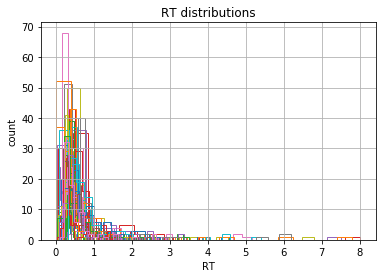

In [51]:
# Plot RT distributions
acc_data = hddm.utils.flip_errors(acc_data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in acc_data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
plt.savefig('hddm/acc_rt_hist.pdf')

### Model 1: Span decreases drift rate, but does not affect decision threshold
*a ~ Category & v ~ Category*

The decision boundaries have the same distance to each other in each span condition. Participants make decisions equally carefully in all span conditions.

The drift rate is reduced in higher span conditions. It takes participants longer to gather the required evidence, in accordance with our memory search account. 

In [6]:
# Create basic accuracy model
span_model = hddm.HDDM(acc_data,
                          depends_on={'a': 'Category', 'v': 'Category'},
                          p_outlier=0.05)
span_model.find_starting_values()
span_model.sample(n_sample, burn=n_burn)
span_model.get_traces().to_csv("hddm/span_traces.csv")
span_model.gen_stats().to_csv('hddm/span_stats.csv')

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 15000 of 15000 complete in 2093.2 sec

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [7]:
# # Create accuracy model with bias and sds
# acc_model_comp = hddm.HDDM(acc_data,
#                            depends_on={'a': 'Category', 'v': 'Category'},
#                            include=('z', 'sv', 'st', 'sz'),
#                            p_outlier=0.05)
# acc_model_comp.find_starting_values()
# acc_model_comp.sample(n_sample, burn=n_burn)
# acc_model_comp.get_traces().to_csv("hddm/acc_traces_comp.csv")
# acc_model_comp.gen_stats().to_csv('hddm/acc_stats_comp.csv')

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 15001 of 15000 complete in 17835.4 sec

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


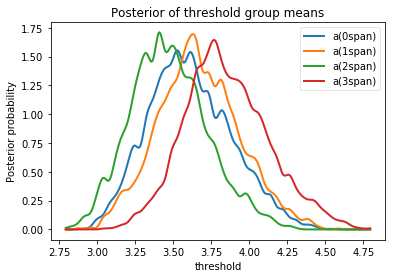

In [11]:
hddm.analyze.plot_posterior_nodes(span_model.nodes_db.node[['a(0span)', 'a(1span)', 'a(2span)', 'a(3span)']])
plt.ylabel('Posterior probability')
plt.savefig('hddm/span_model_a.pdf')

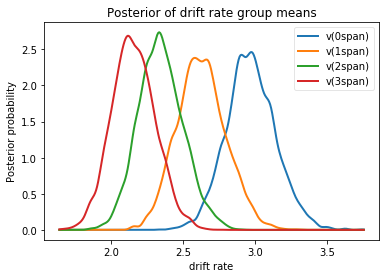

In [12]:
hddm.analyze.plot_posterior_nodes(span_model.nodes_db.node[['v(0span)', 'v(1span)', 'v(2span)', 'v(3span)']])
plt.ylabel('Posterior probability')
plt.savefig('hddm/span_model_v.pdf')

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


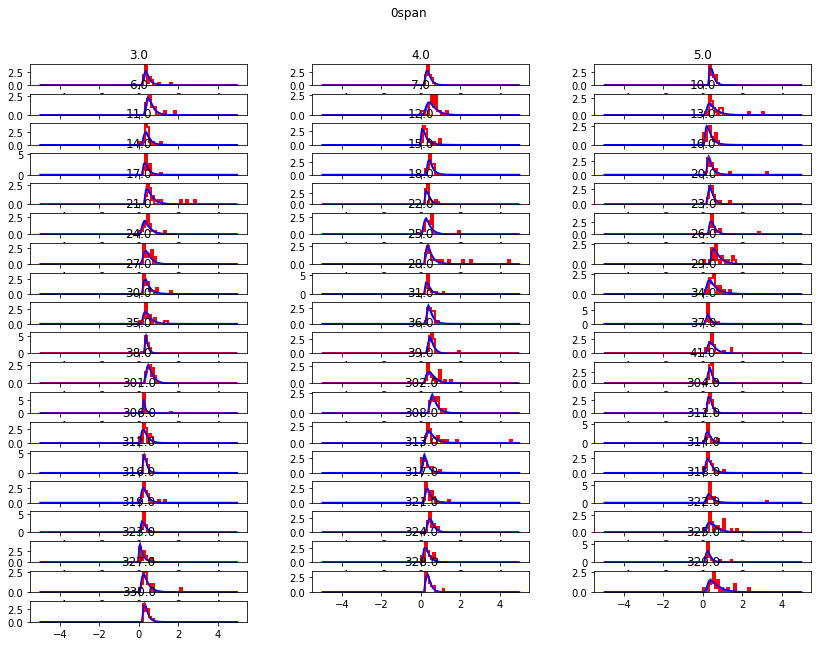

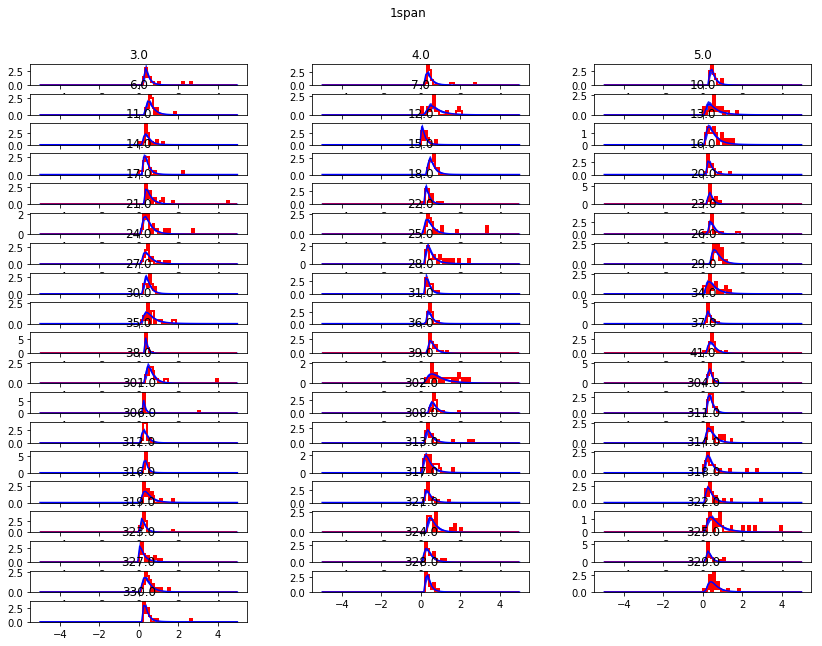

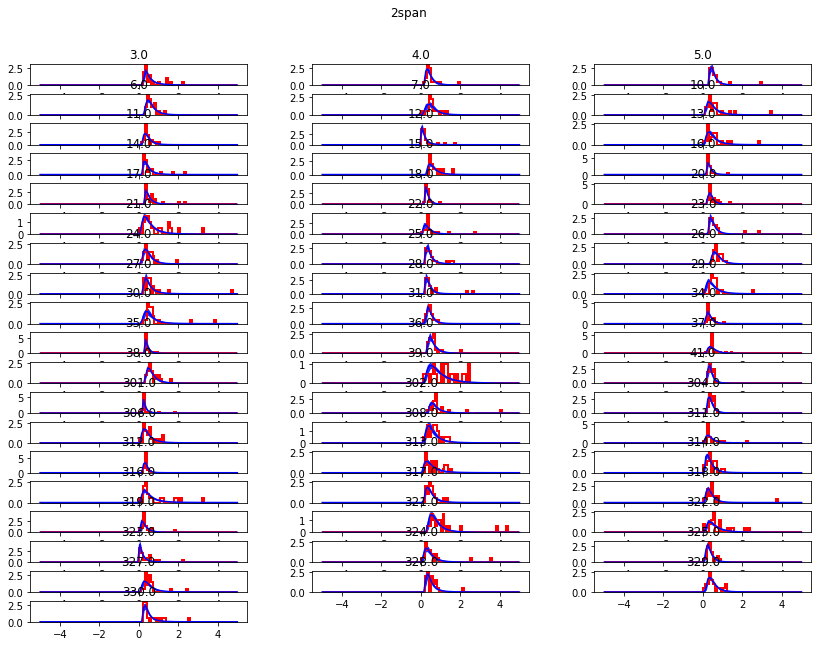

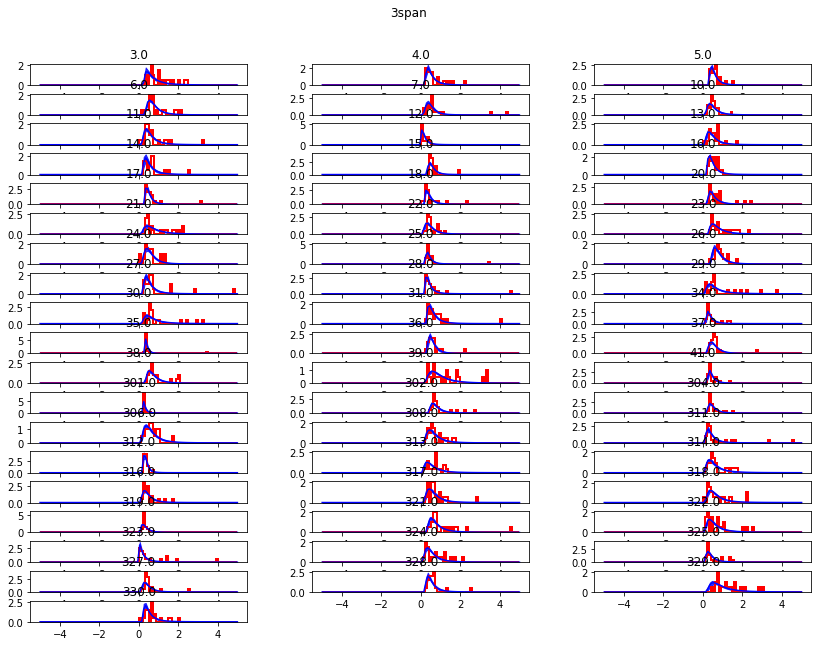

In [13]:
span_model.plot_posterior_predictive(figsize=(14, 10))
plt.savefig('hddm/span_posterior_predictive.pdf')

### Model 2: Pupil pattern ...
*a ~ ppg & v ~ ppg* (ppg groups) and *a ~ ppg_cont & v ~ ppg_cont* (continuous ppg measure)

In [6]:
# Create basic accuracy model
ppg_model = hddm.HDDM(acc_data,
                      depends_on={'a': 'ppg', 'v': 'ppg'},
                      p_outlier=0.05)
ppg_model.find_starting_values()
ppg_model.sample(n_sample, burn=n_burn)
ppg_model.get_traces().to_csv("hddm/ppg_traces.csv")
ppg_model.gen_stats().to_csv('hddm/ppg_traces.csv')

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 15000 of 15000 complete in 2093.2 sec

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


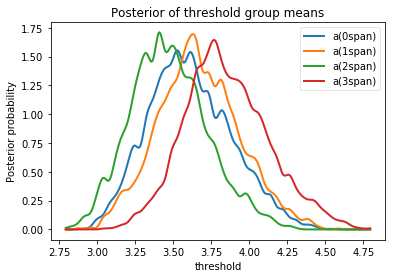

In [11]:
hddm.analyze.plot_posterior_nodes(ppg_model.nodes_db.node[['a(linear)', 'a(inverse-u)']])
plt.ylabel('Posterior probability')
plt.savefig('hddm/ppg_a.pdf')

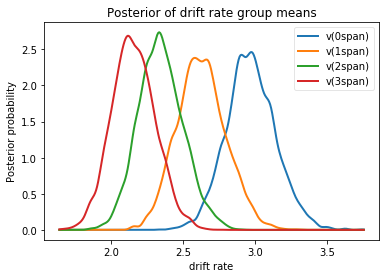

In [12]:
hddm.analyze.plot_posterior_nodes(span_model.nodes_db.node[['v(linear)', 'v(inverse-u)']])
plt.ylabel('Posterior probability')
plt.savefig('hddm/ppg_v.pdf')

In [66]:
# Create accuracy model with ppg
ppg_cont_model = hddm.models.HDDMRegressor(acc_data,
                                           ['a ~ ppg_cont', 'v ~ ppg_cont'],
                                           p_outlier=0.05)
ppg_cont_model.find_starting_values()
ppg_cont_model.sample(n_sample, burn=n_burn)
ppg_cont_model.get_traces().to_csv("hddm/ppg_cont_traces.csv")
ppg_cont_model.gen_stats().to_csv('hddm/ppg_cont_stats.csv')

Adding these covariates:
['a_Intercept', 'a_ppg_cont:Category[0span]', 'a_ppg_cont:Category[1span]', 'a_ppg_cont:Category[2span]', 'a_ppg_cont:Category[3span]']
Adding these covariates:
['v_Intercept', 'v_ppg_cont:Category[0span]', 'v_ppg_cont:Category[1span]', 'v_ppg_cont:Category[2span]', 'v_ppg_cont:Category[3span]']


C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------102%-----------------] 51 of 50 complete in 1223.8 sec

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


PermissionError: [Errno 13] Permission denied: 'hddm/acc_stats_reg.csv'

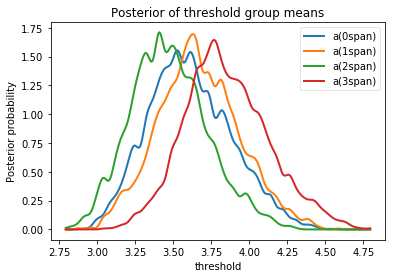

In [11]:
hddm.analyze.plot_posterior_nodes(ppg_cont_model.nodes_db.node[['a_ppg_cont', 'v_ppg_cont']])
plt.ylabel('Posterior probability')
plt.savefig('hddm/ppg_cont.pdf')

## Model 3: Span and pupil pattern
*a ~ ppg_cont * span & v ~ ppg_cont * span*

In [11]:
# Create model with span and ppg
ppg_span_model = hddm.models.HDDMRegressor(acc_data,
                                           ['a ~ ppg_cont*Category', 'v ~ ppg_cont*Category'],
                                           p_outlier=0.05)
ppg_span_model.find_starting_values()
ppg_span_model.sample(n_sample, burn=n_burn)
ppg_span_model.get_traces().to_csv("hddm/ppg_span_traces.csv")
ppg_span_model.gen_stats().to_csv("hddm/ppg_span_stats.csv")

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


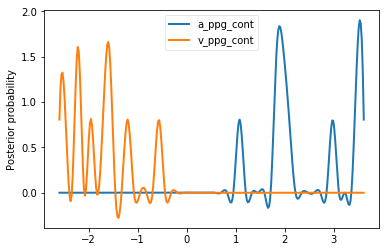

In [13]:
hddm.analyze.plot_posterior_nodes(ppg_span_model.nodes_db.node[['a_ppg_cont', 'v_ppg_cont']])
plt.ylabel('Posterior probability')
plt.savefig('hddm/ppg_span_av_ppg.pdf')

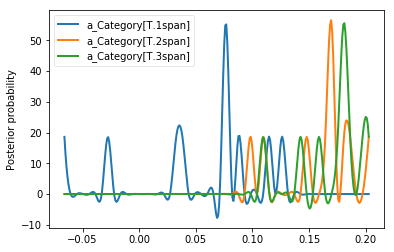

In [14]:
hddm.analyze.plot_posterior_nodes(ppg_span_model.nodes_db.node[['a_Category[T.1span]', 'a_Category[T.2span]', 'a_Category[T.3span]']])
plt.ylabel('Posterior probability')
plt.savefig('hddm/ppg_span_a.pdf')

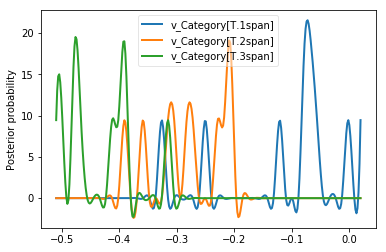

In [15]:
hddm.analyze.plot_posterior_nodes(ppg_span_model.nodes_db.node[['v_Category[T.1span]', 'v_Category[T.2span]', 'v_Category[T.3span]']])
plt.ylabel('Posterior probability')
plt.savefig('hddm/ppg_span_v.pdf')

Plotting a(0span)
Plotting a(1span)
Plotting a(2span)
Plotting a(3span)
Plotting a_std
Plotting v(0span)
Plotting v(1span)
Plotting v(2span)
Plotting v(3span)
Plotting t


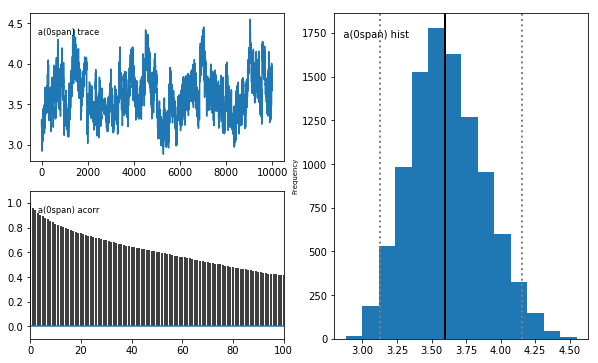

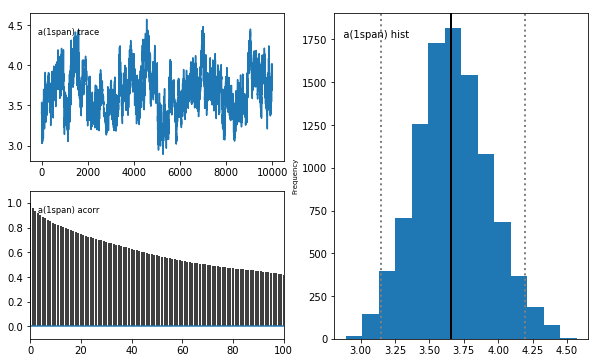

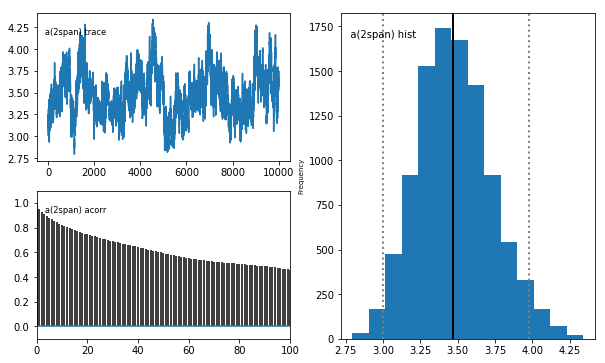

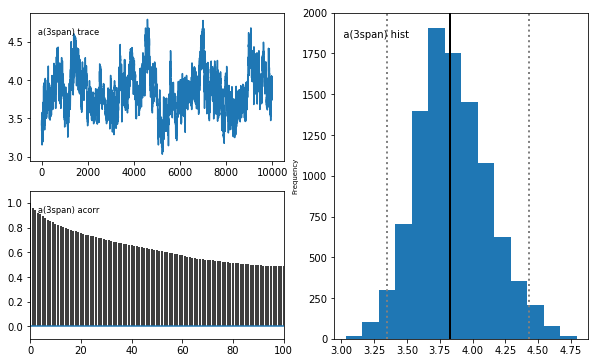

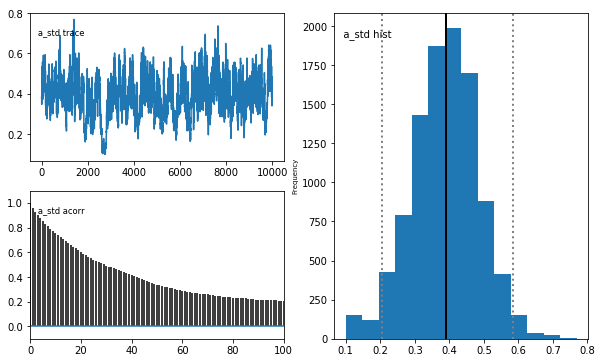

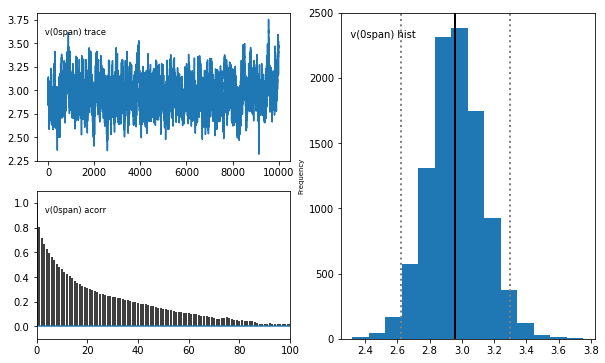

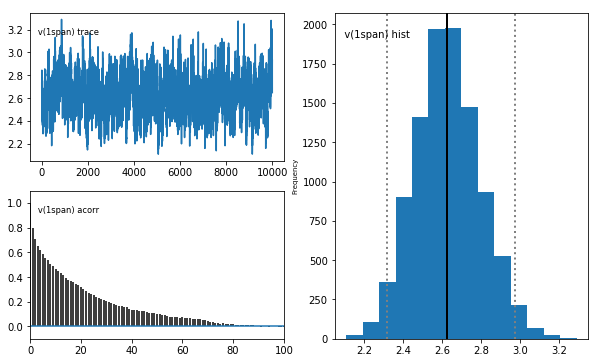

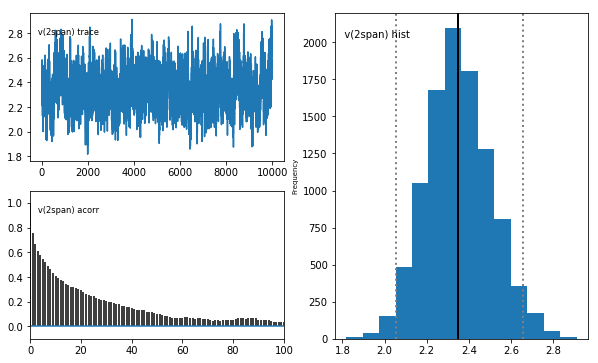

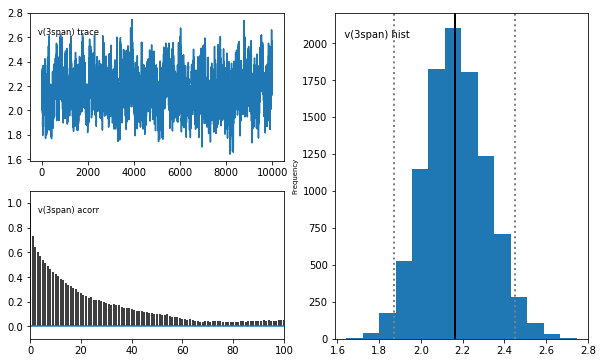

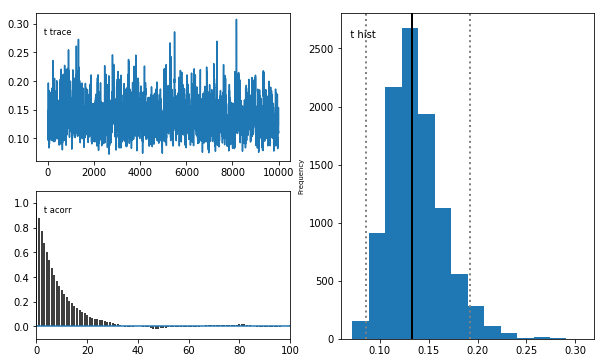

In [8]:
acc_model.plot_posteriors(['a', 't', 'v', 'a_std'])
plt.savefig('hddm/acc_posteriors.pdf')

## Stimulus model

In [14]:
# Bring data in correct shape for STIMULUS CODING MODEL
# In that case, the ‘resp’ column in your data should contain 0 and 1 for the chosen stimulus (or direction),
# not whether the response was correct or not as you would use in accuracy coding.
# You then have to provide another column (referred to as stim_col) which contains information about which the correct response was.
stim_data = all_data.copy()
stim_data = stim_data.rename(columns={"RESP": "response", "CRESP": "correct_response"})
stim_data = stim_data.replace({'response': {'p': 1, 'q': 0}})
stim_data = stim_data.replace({'correct_response': {'p': 1, 'q': 0}})
stim_data.head()

,subj_idx,TrialId,correct_response,response,ACC,rt,Category,SETornoSET
0,3.0,2.0,0,0,1.0,0.427,1span,noSET
1,3.0,3.0,0,0,1.0,1.466,3span,noSET
2,3.0,4.0,0,0,1.0,0.524,1span,noSET
3,3.0,5.0,0,0,1.0,1.470,2span,noSET
4,3.0,6.0,1,1,1.0,0.597,2span,SET


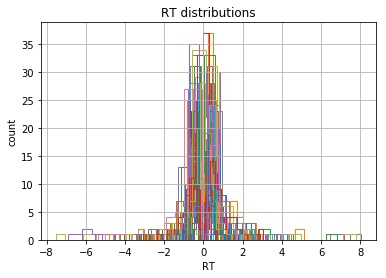

In [15]:
# Plot RT distributions
stim_data = hddm.utils.flip_errors(stim_data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in stim_data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [17]:
# Run hddm on SET vs noSET responses
stim_model = hddm.HDDMStimCoding(stim_data,
                                 split_param='v',
                                 stim_col='correct_response',
                                 depends_on={'a': 'Category', 'v': 'Category'},
                                 p_outlier=0.05)
stim_model.find_starting_values()
stim_model.sample(n_sample, burn=n_burn)
stim_model.get_traces().to_csv("hddm/stim_traces.csv")
stim_model.gen_stats().to_csv('hddm/stim_stats.csv')

C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\scipy\optimize\optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------73%-------           ] 11032 of 15000 complete in 2176.3 secHalting at iteration  11033  of  15000


C:\Users\maria\Anaconda3\envs\SETDDM\lib\site-packages\numpy\core\fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


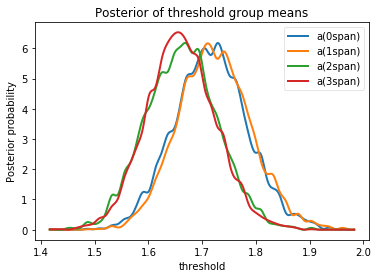

In [18]:
a0, a1, a2, a3 = stim_model.nodes_db.node[['a(0span)', 'a(1span)', 'a(2span)', 'a(3span)']]
hddm.analyze.plot_posterior_nodes([a0, a1, a2, a3])
plt.xlabel('threshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')
plt.savefig('hddm/stim_model_a.pdf')

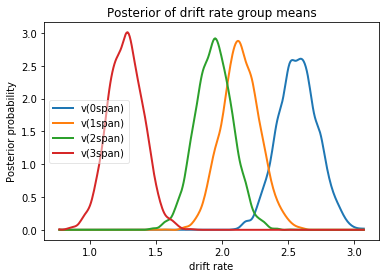

In [19]:
v0, v1, v2, v3 = stim_model.nodes_db.node[['v(0span)', 'v(1span)', 'v(2span)', 'v(3span)']]
hddm.analyze.plot_posterior_nodes([v0, v1, v2, v3])
plt.xlabel('drift rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')
plt.savefig('hddm/stim_model_v.pdf')